In [1]:
import cv2
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import numpy as np
import os
import random
from collections import Counter, defaultdict
from itertools import product, combinations
import math
import cv2
from sklearn.model_selection import train_test_split

random.seed(42)

%matplotlib inline

In [2]:
import keras
from keras.layers import Input, Conv2D, Lambda, average, Dense, Flatten,MaxPooling2D, BatchNormalization, Dropout, Activation, Subtract, subtract
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import numpy.random as rng

Using TensorFlow backend.


In [3]:
IMAGE_SIZE = (70, 70)

def auto_canny(image, sigma=0.33):
	# compute the median of the single channel pixel intensities
	v = np.median(image)
 
	# apply automatic Canny edge detection using the computed median
	lower = int(max(0, (1.0 - sigma) * v))
	upper = int(min(255, (1.0 + sigma) * v))
	edged = cv2.Canny(image, lower, upper)
 
	# return the edged image
	return edged

def process_image(image_location):
    """
        Given the image location, process the image
    """
    # print(image_location)
    
    image = cv2.imread(image_location)
    
    if image.shape[0] != IMAGE_SIZE[0] or image.shape[1] != IMAGE_SIZE[1]:
        # print("Resizing the image: {0}".format(image_location))
        resized_image = cv2.resize(image, IMAGE_SIZE, interpolation = cv2.INTER_AREA)
    else:
        resized_image = image
    
    gray = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    
    # get the edges from the image
    edges = auto_canny(gray)
    #print(edges.shape)
    
    
    # assert(denoised != edges)
    # add the two images in a weighted manner
    weighted_sum = cv2.addWeighted(gray, 0.8, edges, 0.2, 0)
       
    return weighted_sum

In [4]:
type_locations = {"b": ["bb", "wb"], "n": ["bn", "wn"], "k": ["bk", "wk"], "p": ["bp", "wp"], "q": ["bq", "wq"], "r": ["br", "wr"]}
type_name_to_label = { "p":0, "b":1, "n":2, "r":3, "q": 4, "k":5 }

## The below cell need to be replaced with the location of the new data

In [5]:
def get_features_labels(data_path):
    X, y = [], []
    features_with_labels = []
    images = []
    for fol in os.listdir(data_path):
        fol_path = os.path.join(data_path, fol)
        if os.path.isdir(fol_path):
            for file in os.listdir(fol_path):
                if ".jpg" in file:
                    label = -1

                    if fol[0] == "b":
                        label = 0
                    elif fol[0] == "w":
                        label = 1
                    elif fol == "empty":
                        label = 2

                    if label != -1:
                        complete_file_loc = os.path.join(fol_path, file)
                        grayscale_image = process_image(complete_file_loc)
                        images.append(grayscale_image)
                        grayscale_image = grayscale_image[..., np.newaxis]
                        features_with_labels.append({"feature": grayscale_image, "label": label})
            
                    
    random.shuffle(features_with_labels)
    #print(X[0][0])
    #print(X[0][1])
    X = [x["feature"] for x in features_with_labels]
    y = [x["label"] for x in features_with_labels]
    
    X = np.array(X)
    X = X.astype('float32')
    X /= 255

    return np.array(X), np.array(y), images

In [6]:
X_train, y_train, _ = get_features_labels("C:\\Users\\issuser\\Desktop\\ExtendingBoardGamesOnline\\data\\sriraj_v2\\train")
X_test, y_test, test_images = get_features_labels("C:\\Users\\issuser\\Desktop\\ExtendingBoardGamesOnline\\data\\sriraj_v2\\test")
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(len(test_images))

(6486, 70, 70, 1)
(6486,)
(81, 70, 70, 1)
(81,)
81


In [7]:
np.unique(y_test)

array([0, 1, 2])

In [8]:
# batch size
batch_size = 64


# number of training epochs
epochs = 150

required_input_shape = (*IMAGE_SIZE, 1)

In [9]:
model_folder_name = "fine_tune/models"
tensorboard_logs_folder_location = "fine_tune/logs"

In [10]:
from keras import optimizers

def load_3_class_cnn_model(trained_3_class_classifier_location):
    """
        Load the 3 class CNN model
    """
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='valid', input_shape=required_input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
	
    model.add(Conv2D(128, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.6))
    
    model.add(Dense(3))
    model.add(Activation('softmax'))
    model.summary()

    
    # load the model weights
    model.load_weights(trained_3_class_classifier_location)
                           
    adam = optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    return model

In [11]:
trained_model = load_3_class_cnn_model("best_model/custom_cnn_95.hdf5")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 68, 68, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 68, 68, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 68, 68, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 34, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
__________

In [17]:
## Helper method to print a confusion matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
    
import matplotlib
matplotlib.rcParams['figure.figsize'] = [15, 15]

IMAGES_PER_ROW = 5

def plot_mispredicted_images(images, actual_values, predicted_values):
    mis_predictions = actual_values ^ predicted_values
    mis_prediction_indices = np.nonzero(mis_predictions)[0]
    print(mis_prediction_indices)
    
    num_failed_images = len(mis_prediction_indices)
    
    if num_failed_images == 0:
        print("All images predicted correctly.")
        return
        
    
    if num_failed_images == 1:
        print("{0} mispredicted as {1}".format(actual_values[mis_prediction_indices[0]], predicted_values[mis_prediction_indices[0]]))
        plt.imshow(images[mis_prediction_indices[0]], cmap='gray')
        return
    elif num_failed_images < IMAGES_PER_ROW:
        num_images_per_row = 2
    else:
        num_images_per_row = IMAGES_PER_ROW
        
    num_rows = (num_failed_images // num_images_per_row) + int((num_failed_images % num_images_per_row) != 0)

    print("Number of failed images: " + str(num_failed_images))
    print("Num rows: {0}. Num images/row: {1}".format(num_rows, num_images_per_row))
    #print(num_rows)
    #print(num_images_per_row)


    fig, axes = plt.subplots(num_rows, num_images_per_row)

    current_image_idx = 0

    for itr in range(num_rows):
        #print(itr)
        for jtr in range(num_images_per_row):
            if current_image_idx == num_failed_images:
                break
            
            print("{0}, {1}, {2}".format(itr, jtr, current_image_idx))
            axes[itr, jtr].imshow(images[mis_prediction_indices[current_image_idx]], cmap='gray')
            axes[itr, jtr].set_title("{0} predicted as {1}".format(actual_values[mis_prediction_indices[current_image_idx]], predicted_values[mis_prediction_indices[current_image_idx]]))
            #print(current_image_idx)
            current_image_idx += 1

## Check the loaded trained model is behaving as expected

Confusion matrix, without normalization
[[30  0  0]
 [ 0 30  0]
 [10  3  8]]
0.8395061728395061


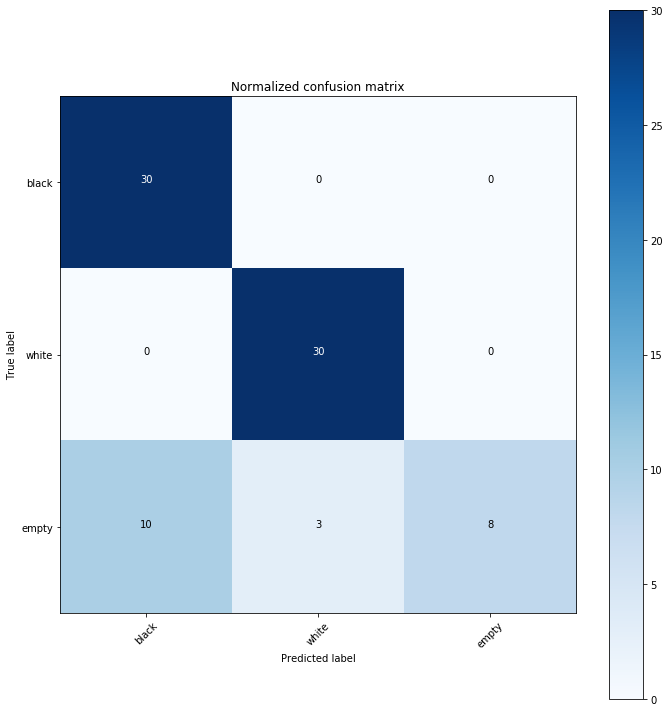

In [13]:
from sklearn.metrics import confusion_matrix, accuracy_score
plt.rcParams["figure.figsize"] = (10,10)
class_names = ["black", "white", "empty"]
test_predictions = trained_model.predict(X_test, batch_size=batch_size)
y_test_pred = [np.argmax(x) for x in test_predictions]
cnf_matrix = confusion_matrix(y_test, y_test_pred)
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False,title='Normalized confusion matrix')
print(accuracy_score(y_test, y_test_pred))

In [14]:
# checkpoint
if not os.path.exists(model_folder_name):
    os.makedirs(model_folder_name)

# tensorboard logs
if not os.path.exists(tensorboard_logs_folder_location):
    os.makedirs(tensorboard_logs_folder_location)

filepath = os.path.join(model_folder_name, "3_class_cnn_fine_tuned.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

earlystop = EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=20, verbose=1, mode='max')

tensorboard = TensorBoard(log_dir=tensorboard_logs_folder_location, histogram_freq=0, write_graph=True, write_images=True)

callbacks_list = [checkpoint, earlystop, tensorboard]

adam = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
trained_model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

hist = trained_model.fit(X_train, y_train, shuffle=True, batch_size=batch_size,
                 epochs=epochs, verbose=1,
                 validation_data=(X_test, y_test), callbacks=callbacks_list)

# Evaluating the model on the test data
score, accuracy = trained_model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score)
print('Test accuracy:', accuracy)

Train on 6486 samples, validate on 81 samples
Epoch 1/150
6486/6486 [==============================] - 2s 357us/step - loss: 0.5074 - acc: 0.8272 - val_loss: 0.1555 - val_acc: 0.9383

Epoch 00001: val_acc improved from -inf to 0.93827, saving model to fine_tune/models\3_class_cnn_fine_tuned.hdf5
Epoch 2/150
6486/6486 [==============================] - 2s 252us/step - loss: 0.3596 - acc: 0.8615 - val_loss: 0.1153 - val_acc: 0.9383

Epoch 00002: val_acc did not improve from 0.93827
Epoch 3/150
6486/6486 [==============================] - 2s 253us/step - loss: 0.3011 - acc: 0.8790 - val_loss: 0.0998 - val_acc: 0.9630

Epoch 00003: val_acc improved from 0.93827 to 0.96296, saving model to fine_tune/models\3_class_cnn_fine_tuned.hdf5
Epoch 4/150
6486/6486 [==============================] - 2s 252us/step - loss: 0.2661 - acc: 0.8947 - val_loss: 0.0931 - val_acc: 0.9630

Epoch 00004: val_acc did not improve from 0.96296
Epoch 5/150
6486/6486 [==============================] - 2s 253us/step - 

# Load the fine-tuned model and perform predictions on the test set and visualize the mispredicted images

Confusion matrix, without normalization
[[30  0  0]
 [ 0 30  0]
 [ 0  0 21]]
1.0


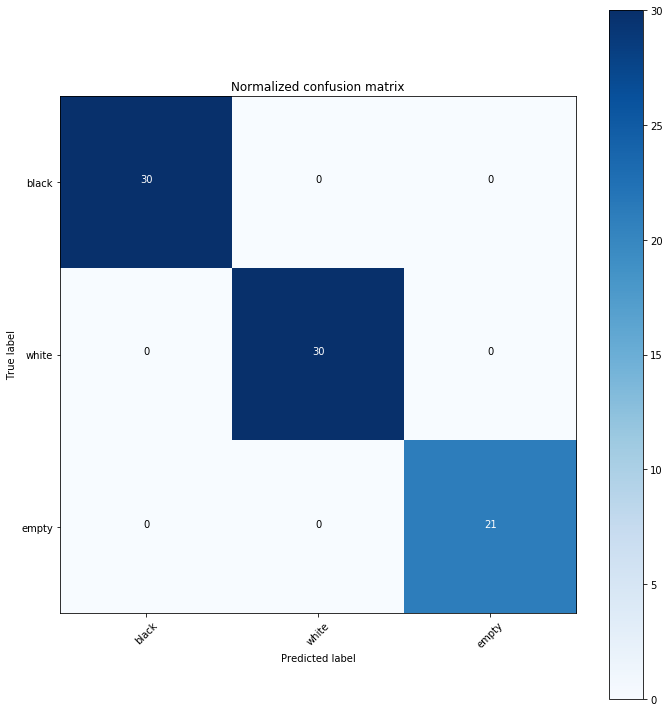

In [15]:
trained_model.load_weights(filepath)
plt.rcParams["figure.figsize"] = (10,10)
class_names = ["black", "white", "empty"]
test_predictions = trained_model.predict(X_test, batch_size=batch_size)
y_test_pred = [np.argmax(x) for x in test_predictions]
cnf_matrix = confusion_matrix(y_test, y_test_pred)
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False,title='Normalized confusion matrix')
print(accuracy_score(y_test, y_test_pred))

In [18]:
# test_images = np.squeeze(X_test)
plot_mispredicted_images(test_images, y_test, y_test_pred)

[]
All images predicted correctly.
